# Hovmoller Temperature Depth

This notebook shows how to calculate a depth-time Hovmoller plot of globally averaged potential temperature from ACCESS-OM2.

First, the preliminaries, including starting a cluster of 8 workers to do the calculation.

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import cmocean as cm
import IPython.display

cc.start_cluster()

netcdf_index loaded.


/home/157/amh157/.local/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


If the link to the dashboard below doesn't work, run this command on a local terminal to set up a SSH tunnel:

  ssh -N -L 37545:127.0.0.1:37545 vdi-n22.nci.org.au -l amh157


Client Scheduler: tcp://127.0.0.1:35328 Dashboard: http://127.0.0.1:37545,Cluster Workers: 4 Cores: 8 Memory: 24.00 GB


**Select an Experiment:**

In [2]:
expt = '1deg_jra55_ryf8485_gfdl50'
#expt= '025deg_jra55v13_ryf8485_spinup_A'

Now, we load an entire temperature dataset, along with the corresponding WOA13 temperature dataset to compute the temperature anomaly.

In [3]:
temp = cc.get_nc_variable(expt, 'ocean.nc', 'temp',
                        chunks={'st_ocean': None}, 
                        time_units="days since 1700-01-01")
temp_WOA13 = cc.get_nc_variable('woa13/10', 'woa13_ts_??_mom10.nc', 'temp').mean('time').compute()
#temp_WOA13 = cc.get_nc_variable('woa13/025', 'woa13_ts_??_mom025.nc', 'temp').mean('time').compute()
temp_anom = temp - temp_WOA13.values - 273.15
IPython.display.clear_output()

Next, we load cell area (denoted $a(x,y,z)$) from the ocean_grid file, construct a mask from the temperature file and make a profile of the total ocean area as a function of depth, $A$, namely
$$ A(z) = \sum_x \sum_y a(x,y,z)$$
*Note that this mask ignores the presence of partial cells, for now*.

In [4]:
area_t = cc.get_nc_variable(expt,'ocean_grid.nc','area_t',n=1).mean('time')
mask = temp.isel(time=0).copy()
mask = mask/mask                 ## This seems pretty dodgy to me, but it works!!
area = mask*area_t
area_sum = area.sum('xt_ocean').sum('yt_ocean')
IPython.display.clear_output()

Now, the mean temperature at each time level can then be computed as 
$$T(z,t) = \frac{\sum_x \sum_y a(x,y,z) \theta(x,y,z,t)}{A(z)}$$
where $T$ is the average temperature and $\theta$ the potential temperature.

In [5]:
var =area_t*temp_anom
temp_hov = var.sum('xt_ocean').sum('yt_ocean').compute()
temp_hov = temp_hov/area_sum

We can use xarray for a quick and dirty plot of this data:

/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


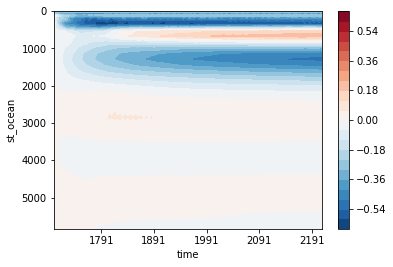

In [6]:
temp_hov.T.plot.contourf(levels=25,yincrease=False)

Alternatively, we could put a little more effort into plotting, including expansion of the upper 1000m:

Text(0.5,1,'Horizontally averaged evolution of potential temperature')

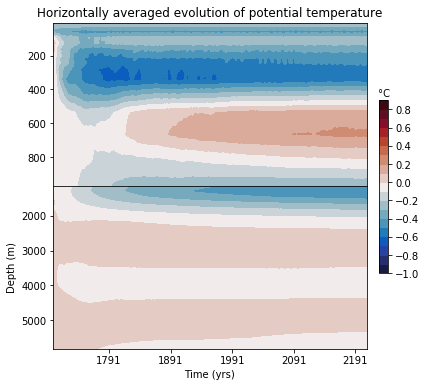

In [7]:
t_up = temp_hov.sel(st_ocean=slice(0,1000))
levs = np.arange(-1,1,0.1)
fig,ax = plt.subplots(2,1,sharex=True,figsize=(6,6))
plt.subplots_adjust(hspace=0,right=0.85)

t_up.T.plot.contourf(ax=ax[0],levels=levs,cmap = cm.cm.balance,yincrease=False,add_colorbar=False)
ax[0].set_ylabel('')

t_lo = temp_hov.sel(st_ocean=slice(1000,6000))
p1=t_lo.T.plot.contourf(ax=ax[1],levels=levs,cmap = cm.cm.balance,yincrease=False,add_colorbar=False)
plt.ylabel('Depth (m)')
plt.xlabel('Time (yrs)')

ax1 = plt.axes([0.88,0.3,0.02,0.4])
cb = plt.colorbar(p1,cax=ax1,orientation='vertical')
ax1.xaxis.set_label_position("top")
cb.ax.set_xlabel('°C')

ax[0].set_title('Horizontally averaged evolution of potential temperature')
